# Project 2


In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
import torchvision

## Loading the dataset CIFAR10

We are told to classify birds from cats in the CIFAR10 dataset. This means that we will only use the images that are labeled as birds or cats. In the CIFAR10 these labels are 2 and 3 respectively. We will have the training, validation and test datasets.

In [47]:
from torchvision import datasets, transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#Filtering the birds and cats images from the train set
trainset.targets = torch.tensor(trainset.targets)
mask = (trainset.targets == 2) | (trainset.targets == 3)
trainset.targets = (trainset.targets[mask] - 2)  # Adjust labels to be 0 for the birds and 1 cats
trainset.data = trainset.data[mask.numpy().astype(bool)]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#Filtering the birds and cats images from the test set
testset.targets = torch.tensor(testset.targets)
mask = (testset.targets == 2) | (testset.targets == 3)
testset.targets = (testset.targets[mask] - 2)  # Adjust labels to be 0 for the birds and 1 cats
testset.data = testset.data[mask.numpy().astype(bool)]

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Splitting the training into train and valid (80/20)

## Implementation of a Lenet5

In [48]:
class Lenet5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.
            
            #nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes. 

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.criterion = nn.CrossEntropyLoss()
        #self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")
        
        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)  
        
                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
    
    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                outputs = self(images)
                #print(torch.exp(outputs))
                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [49]:
model = Lenet5()
model.trainloop(trainloader,testloader,30)


GPU not available, running CPU
Epoch 1. Training loss: 0.578573, Validation loss: 0.535593, Time per epoch: 1.799567 seconds
Epoch 2. Training loss: 0.514067, Validation loss: 0.509710, Time per epoch: 1.665339 seconds
Epoch 3. Training loss: 0.481113, Validation loss: 0.486397, Time per epoch: 1.700247 seconds
Epoch 4. Training loss: 0.450988, Validation loss: 0.470850, Time per epoch: 1.769539 seconds
Epoch 5. Training loss: 0.430245, Validation loss: 0.465892, Time per epoch: 1.731444 seconds
Epoch 6. Training loss: 0.418457, Validation loss: 0.449630, Time per epoch: 1.728815 seconds
Epoch 7. Training loss: 0.394561, Validation loss: 0.447469, Time per epoch: 1.745470 seconds
Epoch 8. Training loss: 0.380024, Validation loss: 0.425888, Time per epoch: 1.805145 seconds
Epoch 9. Training loss: 0.370778, Validation loss: 0.436547, Time per epoch: 1.754657 seconds
Epoch 10. Training loss: 0.354730, Validation loss: 0.433946, Time per epoch: 1.741970 seconds
Epoch 11. Training loss: 0.3

## Computing the Calibration Curve

In [50]:
# First we select the true labels of the test data
true_labels = testloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model.compute_accuracy(testloader)
outputs = np.concatenate(outputs) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

print(predicted_prob)
print(max(predicted_prob))

[0.9997206, 0.9111221, 0.031175256, 0.0030621013, 0.4359715, 0.93190277, 0.06667537, 0.00928056, 0.00033853232, 1.5116006e-09, 0.9965788, 0.014809325, 3.678592e-08, 0.9577156, 0.5667469, 0.046578154, 0.00020382612, 0.051381346, 0.9978584, 0.22967798, 0.0006351357, 0.9997058, 0.81880015, 0.003564571, 0.39917713, 0.99646306, 0.009482484, 0.12445963, 0.0010393992, 0.9944306, 0.9981317, 2.6670425e-06, 0.0003372286, 1.970358e-07, 0.99999106, 0.0074666715, 0.00046981266, 0.00049875194, 0.0012292059, 0.21585114, 0.99464756, 0.00016708767, 0.909383, 2.5699062e-06, 1.9545054e-08, 4.2849464e-05, 0.9984145, 0.04380137, 0.97117555, 0.0001427655, 0.035937157, 0.012784133, 0.0031998013, 0.9457389, 0.00018242614, 0.019781861, 0.91509885, 0.17497088, 0.0032512108, 0.7662176, 0.00067198084, 0.010917957, 0.013794019, 0.9081843, 0.44804603, 2.3607356e-06, 1.5910162e-05, 0.759872, 0.5204522, 0.92653537, 0.08303374, 2.9531898e-11, 0.5254375, 0.002473451, 0.0119326, 5.5178945e-15, 0.98958325, 2.6098973e-05,

True labels:  [0.31301731 0.87034277] 

Predicted Probabilities: [0.04672468 0.91624192]


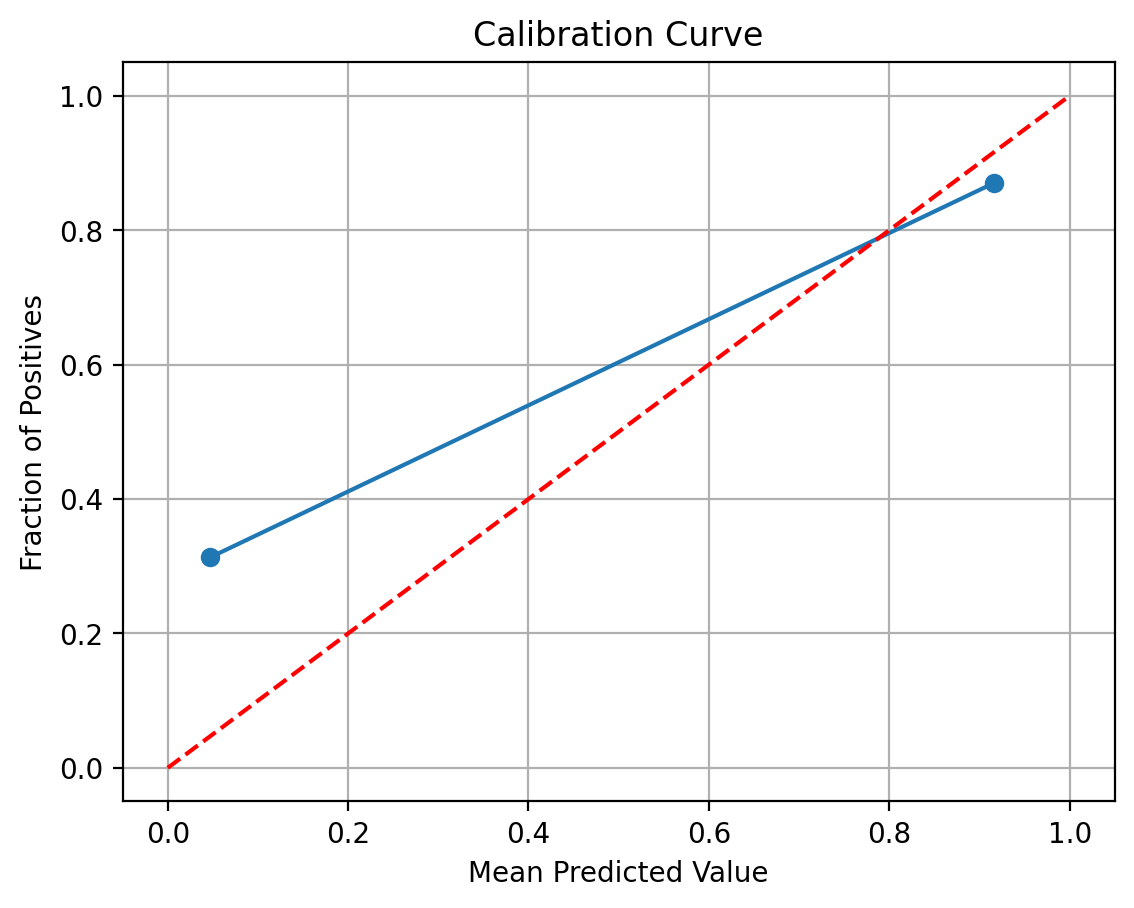

In [55]:
import numpy as np
from sklearn.calibration import calibration_curve


prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=2)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [61]:
import numpy as np

# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.1561


In [66]:
print(n)
print(M)
print(samples_per_bin)

2000
2
1000.0
